In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point
from itertools import chain
import geoplot
import shapely
import gstools as gs
import numpy as np
import matplotlib.patches as mpatches
import os

In [21]:
global_or_US = "global"
growth_df_global = gpd.GeoDataFrame(
    pd.read_pickle(
        "seaweed_growth_rate_clustered_" + global_or_US + ".pkl"
    )
)

In [22]:
growth_df_global

months_since_war             -3        -2            -1             0  \
-78.152090 194.562505  0.000011  0.000007  1.080906e-06  4.340751e-08   
           195.687505  0.000014  0.000011  1.888677e-06  5.606738e-08   
           196.812505  0.000015  0.000012  2.335622e-06  5.815494e-08   
           197.937506  0.000016  0.000012  2.053414e-06  4.234192e-08   
           320.562509  0.000002  0.000001  9.279054e-08  1.242968e-10   
...                         ...       ...           ...           ...   
 89.616591 183.608458  0.000000  0.000000  2.971729e-10  9.621325e-09   
 89.663855 334.470704  0.000000  0.000000  3.767500e-10  1.093077e-08   
           305.529436  0.000000  0.000000  3.742607e-10  1.071672e-08   
 89.706409 122.527067  0.000000  0.000000  3.408817e-10  9.886951e-09   
 89.706410 157.472790  0.000000  0.000000  3.198583e-10  9.654595e-09   

months_since_war                  1             2             3             4  \
-78.152090 194.562505  0.000000e+00  0.000000e+00  0.000000e+00  2.872584e-11   
           195.687505  0.000000e+00  0.000000e+00  0.000000e+00  4.123149e-11   
           196.812505  0.000000e+00  0.000000e+00  0.000000e+00  5.187178e-11   
           197.937506  0.000000e+00  0.000000e+00  0.000000e+00  1.473226e-10   
           320.562509  0.000000e+00  0.000000e+00  0.000000e+00  1.713758e-14   
...                             ...           ...           ...           ...   
 89.616591 183.608458  4.000441e-08  4.860006e-11  3.434996e-11  8.758652e-12   
 89.663855 334.470704  4.828565e-08  5.368022e-11  5.413988e-11  1.067863e-11   
           305.529436  4.775904e-08  5.703088e-11  4.555200e-11  9.286521e-12   
 89.706409 122.527067  4.042983e-08  4.184417e-11  3.622149e-11  1.025945e-11   
 89.706410 157.472790  3.972105e-08  4.692853e-11  3.334951e-11  9.374161e-12   

months_since_war                  5             6  ...           108  \
-78.152090 194.562505  1.656558e-08  3.199722e-07  ...  7.684799e-09   
           195.687505  2.117739e-08  3.625968e-07  ...  1.514082e-08   
           196.812505  2.318916e-08  3.446465e-07  ...  1.910014e-08   
           197.937506  2.577637e-08  3.659875e-07  ...  1.740600e-08   
           320.562509  9.819242e-13  1.167511e-11  ...  1.843058e-10   
...                             ...           ...  ...           ...   
 89.616591 183.608458  3.237654e-13  0.000000e+00  ...  1.391816e-08   
 89.663855 334.470704  3.672863e-13  0.000000e+00  ...  1.612717e-08   
           305.529436  3.346805e-13  0.000000e+00  ...  1.590135e-08   
 89.706409 122.527067  4.290349e-13  0.000000e+00  ...  1.431736e-08   
 89.706410 157.472790  3.882104e-13  0.000000e+00  ...  1.410699e-08   

months_since_war                109           110           111           112  \
-78.152090 194.562505  0.000000e+00  0.000000e+00  0.000000e+00  1.695093e-11   
           195.687505  0.000000e+00  0.000000e+00  0.000000e+00  4.782390e-11   
           196.812505  0.000000e+00  0.000000e+00  0.000000e+00  1.223867e-10   
           197.937506  0.000000e+00  0.000000e+00  0.000000e+00  2.909292e-10   
           320.562509  0.000000e+00  0.000000e+00  0.000000e+00  1.436959e-12   
...                             ...           ...           ...           ...   
 89.616591 183.608458  1.329644e-07  3.530576e-07  3.399879e-07  2.898518e-07   
 89.663855 334.470704  1.454482e-07  3.631096e-07  2.506540e-07  3.870041e-07   
           305.529436  1.445498e-07  3.696052e-07  2.706320e-07  3.848347e-07   
 89.706409 122.527067  1.356530e-07  3.430645e-07  2.930233e-07  2.997041e-07   
 89.706410 157.472790  1.347699e-07  3.453279e-07  3.142684e-07  2.971347e-07   

months_since_war                113           114           115           116  \
-78.152090 194.562505  4.333771e-08  1.198245e-06  9.928892e-06  5.656922e-05   
           195.687505  6.924070e-08  1.572849e-06  1.059330e-05  6.042587e-05   
           196.812505  6.846431e-08  1.584246e-06  1.071534e-05  6.37

In [23]:
def prepare_geometry(growth_df):
    """
    Prepares the geometry for the growth_df. For some reason the spatial data has
    a longitude that is 0-360 instead of -180 to 180. This function converts it to
    the latter
    """
    growth_df["latlon"] = growth_df.index
    growth_df["latitude"] = growth_df["latlon"].str[0]
    growth_df["longitude"] = growth_df["latlon"].str[1]
    growth_df["longitude"] = growth_df["longitude"].apply(lambda x: x - 360 if x > 180 else x)
    growth_df["geometry"] = growth_df[["longitude", "latitude"]].apply(tuple, axis=1).apply(Point)
    growth_df = growth_df[["cluster", "geometry"]]
    growth_df = gpd.GeoDataFrame(growth_df)
    return growth_df

In [24]:
growth_df_global = prepare_geometry(growth_df_global)
growth_df_global

months_since_war       cluster                      geometry
-78.152090 194.562505        0  POINT (-165.43749 -78.15209)
           195.687505        0  POINT (-164.31249 -78.15209)
           196.812505        0  POINT (-163.18749 -78.15209)
           197.937506        0  POINT (-162.06249 -78.15209)
           320.562509        0   POINT (-39.43749 -78.15209)
...                        ...                           ...
 89.616591 183.608458        0   POINT (-176.39154 89.61659)
 89.663855 334.470704        0    POINT (-25.52930 89.66386)
           305.529436        0    POINT (-54.47056 89.66386)
 89.706409 122.527067        0    POINT (122.52707 89.70641)
 89.706410 157.472790        0    POINT (157.47279 89.70641)

[86212 rows x 2 columns]

In [25]:
growth_df_global.shape

(86212, 2)

In [26]:
growth_df_global[growth_df_global.is_valid].shape

(86212, 2)

In [27]:
growth_df = pd.read_pickle("seaweed_growth_rate_clustered_US.pkl")

# overall mean by cluster
growth_df.groupby("cluster").mean().mean(axis=1)

cluster
0    0.088007
1    0.172486
2    0.071954
3    0.118033
4    0.023120
dtype: float64

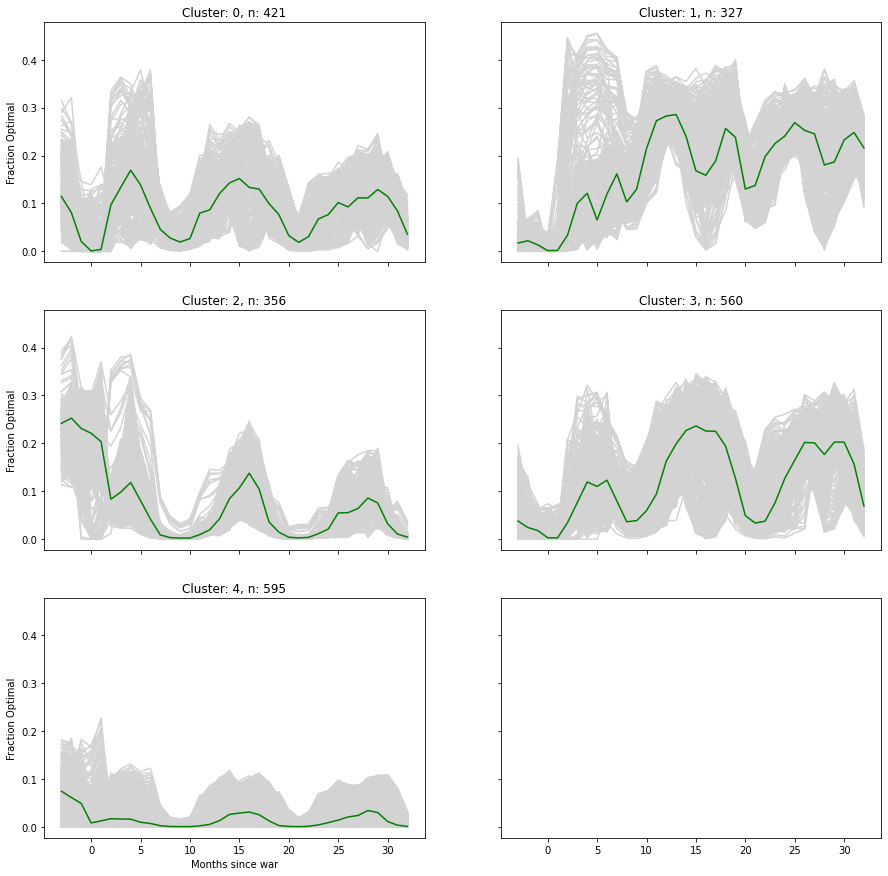

In [28]:
fix, axes = plt.subplots(nrows=3, ncols=2, sharey=True, sharex=True, figsize=(15, 15))

axes = axes.flatten()
for cluster, cluster_df in growth_df.groupby("cluster"):
    del(cluster_df["cluster"])
    ax = axes[cluster]
    cluster_df.transpose().plot(ax=ax, color="lightgrey", legend=False)
    cluster_df.median().transpose().plot(ax=ax, color="green", legend=False)
    ax.set_ylabel("Fraction Optimal")
    ax.set_xlabel("Months since war")
    ax.set_title("Cluster: " + str(cluster) + ", n: " + str(cluster_df.shape[0]))

In [29]:
growth_df["latlon"] = growth_df.index
growth_df['latitude'] = growth_df["latlon"].str[0]
growth_df['longitude'] = growth_df['latlon'].str[1]
growth_df['longitude'] = growth_df[growth_df["longitude"]>180]["longitude"] - 360
#print(growth_df.longitude.min())

In [30]:
growth_df["geometry"] = growth_df[['longitude','latitude']].apply(tuple, axis=1)
growth_df["geometry"] = growth_df["geometry"].apply(Point)
growth_df = growth_df[["cluster", "geometry"]]
growth_df = gpd.GeoDataFrame(growth_df)
growth_df.set_crs(epsg=4326).to_file("clusters_shp/clusters.shp")
growth_df

,months_since_war,cluster,geometry
17.474949,296.964984,1,POINT (-63.03502 17.47495)
17.480288,295.841260,1,POINT (-64.15874 17.48029)
17.485865,294.717527,1,POINT (-65.28247 17.48587)
17.491679,293.593785,1,POINT (-66.40622 17.49168)
17.497726,292.470032,1,POINT (-67.52997 17.49773)
...,...,...,...
52.808242,229.511355,4,POINT (-130.48865 52.80824)
52.928145,228.400686,4,POINT (-131.59931 52.92815)
53.342084,229.672963,4,POINT (-130.32704 53.34208)
53.464323,228.563404,4,POINT (-131.43660 53.46432)


In [31]:
buffered = gpd.GeoDataFrame(growth_df.buffer(0.65))
buffered["cluster"] = growth_df["cluster"]
buffered.columns=["geometry", "cluster"]
cluster_dict = {0:"high/low",
               1:"low/medium",
               2:"low/low",
               3:"low/high",
               4:"medium/medium"
               }
buffered["cluster_names"] = buffered["cluster"].map(cluster_dict)


In [32]:
global_map = gpd.read_file("../geospatial_information/Countries/ne_50m_admin_0_countries.shp")


(-130.0, -65.0)

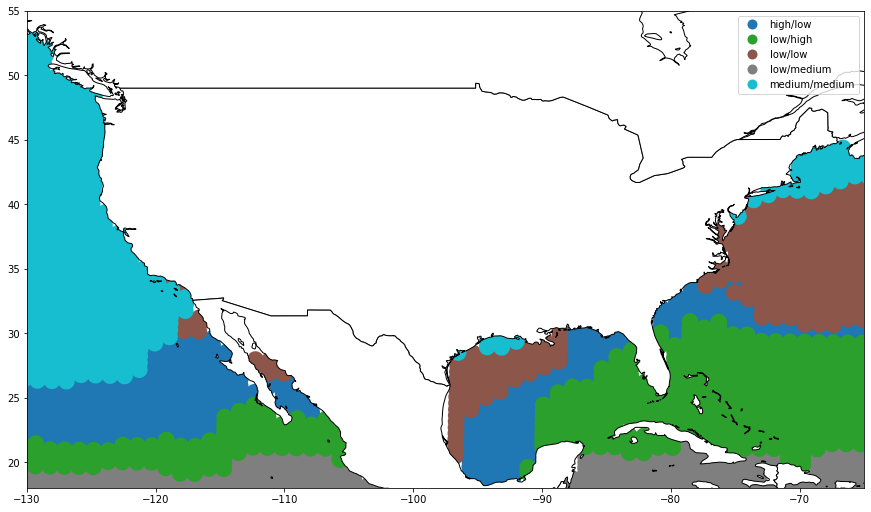

In [33]:
cluster_dissolved = buffered.dissolve(by="cluster")
cluster_dissolved.set_crs(epsg=4326,inplace=True)
cluster_dissolved.to_crs(global_map.crs,inplace=True)
cluster_dissolved["cluster"] = cluster_dissolved.index
ax = cluster_dissolved.plot(column="cluster_names", legend=True)
fig = plt.gcf()
fig.set_size_inches(15,15)
global_map.plot(ax=ax, color="white", edgecolor="black")
ax.set_ylim(18,55)
ax.set_xlim(-130,-65)

In [34]:
growth_df

,months_since_war,cluster,geometry
17.474949,296.964984,1,POINT (-63.03502 17.47495)
17.480288,295.841260,1,POINT (-64.15874 17.48029)
17.485865,294.717527,1,POINT (-65.28247 17.48587)
17.491679,293.593785,1,POINT (-66.40622 17.49168)
17.497726,292.470032,1,POINT (-67.52997 17.49773)
...,...,...,...
52.808242,229.511355,4,POINT (-130.48865 52.80824)
52.928145,228.400686,4,POINT (-131.59931 52.92815)
53.342084,229.672963,4,POINT (-130.32704 53.34208)
53.464323,228.563404,4,POINT (-131.43660 53.46432)


In [35]:
growth_df["cluster_names"] = growth_df["cluster"].map(cluster_dict)


In [36]:
eez = gpd.read_file("../geospatial_information/EEZ/eez_boundaries_v11.shp")
eez = eez[eez["SOVEREIGN1"]=="United States"]
eez

,LINE_ID,LINE_NAME,LINE_TYPE,MRGID_SOV1,MRGID_TER1,TERRITORY1,SOVEREIGN1,MRGID_TER2,TERRITORY2,MRGID_SOV2,...,SOURCE2,URL2,SOURCE3,URL3,ORIGIN,DOC_DATE,MRGID_JREG,JOINT_REG,LENGTH_KM,geometry
117,1297.0,American Samoa (United States) - Cook Islands ...,Treaty,2204.0,8670.0,American Samoa,United States,8672.0,Cook Islands,2227.0,...,Treaty between the United States of America an...,http://www.marineregions.org/documents/USA-COK...,None,None,Database,1980-06-11,0.0,None,1036.0,"LINESTRING (-166.64306 -17.55778, -166.02750 -..."
157,1345.0,American Samoa (United States) - Tokelau (New ...,Treaty,2204.0,8670.0,American Samoa,United States,8675.0,Tokelau,2227.0,...,None,None,None,None,Database,1980-12-02,0.0,None,590.0,"LINESTRING (-168.51667 -10.02389, -169.78056 -..."
158,1346.0,American Samoa (United States) - Niue (New Zea...,Treaty,2204.0,8670.0,American Samoa,United States,8673.0,Niue,2227.0,...,None,None,None,None,Database,1997-05-13,0.0,None,517.0,"LINESTRING (-166.64194 -17.55500, -166.66056 -..."
171,1369.0,Puerto Rico (United States) - Venezuela,Treaty,2204.0,8641.0,Puerto Rico,United States,2201.0,Venezuela,2201.0,...,Maritime Boundary: Venezuela - USA,http://www.marineregions.org/documents/ls91.jpg,None,None,Database,1978-03-28,0.0,None,311.0,"LINESTRING (-65.98140 15.65491, -66.11917 15.5..."
221,1886.0,Guam (United States) - Micronesia,Treaty,2204.0,8599.0,Guam,United States,8595.0,Micronesia,8595.0,...,None,None,None,None,Database,2014-08-01,0.0,None,828.0,"LINESTRING (141.21875 13.09764, 141.34719 12.9..."
253,1924.0,Howland and Baker islands (United States) - Ph...,Treaty,2204.0,48684.0,Howland and Baker islands,United States,8658.0,Phoenix Group,2116.0,...,None,None,None,None,Database,2014-11-04,0.0,None,613.0,"LINESTRING (-177.45297 -3.01483, -177.28460 -2..."
256,1927.0,Jarvis Island (United States) - Line Group (Ki...,Treaty,2204.0,8668.0,Jarvis Island,United States,8657.0,Line Group,2116.0,...,None,None,None,None,Database,2014-11-04,0.0,None,1014.0,"LINESTRING (-158.30397 -3.27175, -158.18572 -3..."
257,1929.0,Palmyra Atoll (United States) - Line Group (Ki...,Treaty,2204.0,8669.0,Palmyra Atoll,United States,8657.0,Line Group,2116.0,...,None,None,None,None,Database,2014-11-04,0.0,None,710.0,"LINESTRING (-163.06472 2.65967, -162.18732 3.9..."
285,2067.0,United States Virgin Islands (United States) -...,Treaty,2204.0,8642.0,United States Virgin Islands,United States,2201.0,Venezuela,2201.0,...,Maritime Boundary: Venezuela - USA,http://www.marineregions.org/documents/ls91.jpg,None,None,Database,1978-03-28,0.0,None,243.0,"LINESTRING (-64.01889 16.74694, -64.10861 16.7..."
336,3649.0,Jarvis Island (United States) 200 NM,200 NM,2204.0,8668.0,Jarvis Island,United States,0.0,None,0.0,...,None,None,None,None,Buffer,2017-03-28,0.0,None,1069.0,"LINESTRING (-158.31855 -3.28679, -158.31924 -3..."


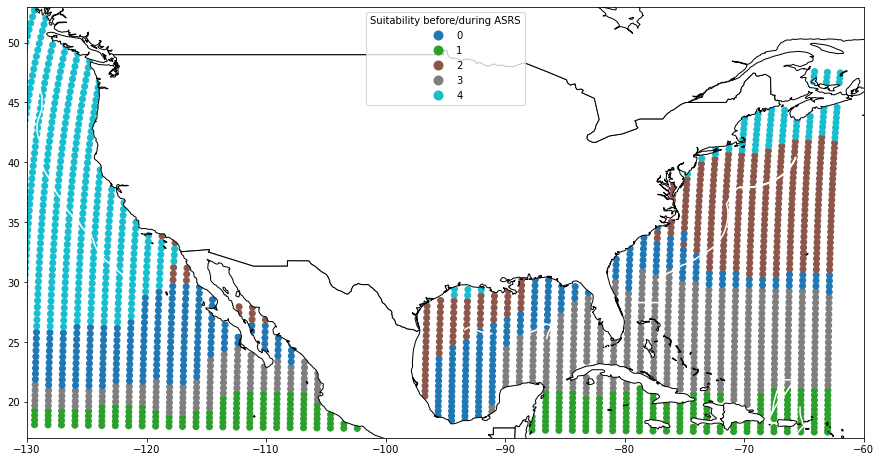

In [46]:
growth_df["cluster"] = growth_df["cluster"].astype(str)
growth_df.set_crs(epsg=4326,inplace=True)
growth_df.to_crs(global_map.crs,inplace=True)
#ax = geoplot.voronoi(growth_df, hue="cluster_names", legend=True, linewidth=0.1)
ax = growth_df.plot(column="cluster", legend=True)
legend = ax.get_legend()
legend.set_title("Suitability before/during ASRS")
legend.set_facecolor="white"
fig = plt.gcf()
fig.set_size_inches(15,15)
eez.to_crs(global_map.crs).plot(ax=ax,facecolor="none", edgecolor='white', lw=1.5)
global_map.plot(ax=ax, color="white", edgecolor="black")
ax.set_ylim(17,53)
ax.set_xlim(-130,-60)
plt.savefig("clusters_US.png", dpi=300, bbox_inches="tight")

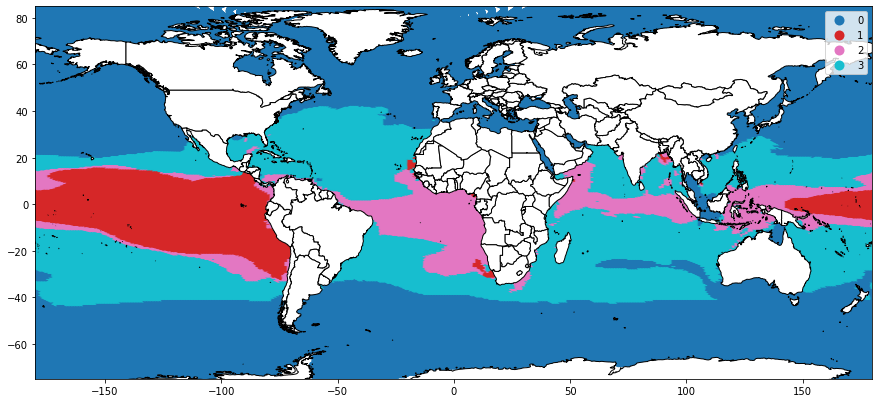

In [52]:
growth_df_global.cluster = growth_df_global.cluster.astype(str)
ax = growth_df_global.plot(column="cluster", legend=True)
global_map.plot(ax=ax, color="white", edgecolor="black")
fig = plt.gcf()
fig.set_size_inches(15,15)
ax.set_ylim(-75, 85)
ax.set_xlim(-180,180)
plt.savefig("test.png", dpi=400)